In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, average_precision_score, brier_score_loss
)

# XGBoost
from xgboost import XGBClassifier

sns.set_style("whitegrid")
pd.set_option("display.max_columns", 200)

RANDOM_STATE = 42
N_SPLITS = 5

In [2]:
data_path = "../data/master_features_v2.csv"
print("Loading:", data_path)
df = pd.read_csv(data_path, low_memory=False)
print("Shape:", df.shape)

# normalize column names to lowercase for safe referencing
df.columns = df.columns.str.lower()
display(df.head(3))
df.info(verbose=False)

Loading: ../data/master_features_v2.csv
Shape: (2833180, 52)


,i_date,page_serial,referrer_hash,view_coupon_id_hash,user_id_hash,session_id_hash,purchaseid_hash,reg_date,sex_id,age,withdraw_date,pref_name,capsule_text,genre_name,price_rate,catalog_price,discount_price,dispfrom,dispend,dispperiod,validfrom,validend,validperiod,usable_date_mon,usable_date_tue,usable_date_wed,usable_date_thu,usable_date_fri,usable_date_sat,usable_date_sun,usable_date_holiday,usable_date_before_holiday,large_area_name,ken_name,small_area_name,coupon_id_hash_x,coupon_id_hash_y,target_purchase,visit_day_of_week,visit_is_weekend,visit_hour,visit_month,discount_value,validity_duration_days,user_age_days,user_total_views,user_unique_views,user_total_purchases,user_conversion_rate,user_preferred_genre,user_max_views_same_coupon,avg_time_between_visits
0,2012-03-28 14:15:00,7,7d3892e54acb559ae36c459978489330,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,Unknown,2012-03-28 14:14:18,f,25,Unknown,Unknown,宅配,宅配,78.0,7200.0,1575.0,2012-03-26 12:00:00,2012-03-30 12:00:00,4.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,関東,東京都,新宿・高田馬場・中野・吉祥寺,34c48f84026e08355dc3bd19b427f09a,34c48f84026e08355dc3bd19b427f09a,1,2,0,14,3,5625.0,0.0,0,13,6,5,0.384615,宅配,5,265.833333
1,2012-03-28 14:17:28,9,7d3892e54acb559ae36c459978489330,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,Unknown,2012-03-28 14:14:18,f,25,Unknown,Unknown,宅配,宅配,78.0,7200.0,1575.0,2012-03-26 12:00:00,2012-03-30 12:00:00,4.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,関東,東京都,新宿・高田馬場・中野・吉祥寺,34c48f84026e08355dc3bd19b427f09a,34c48f84026e08355dc3bd19b427f09a,1,2,0,14,3,5625.0,0.0,0,13,6,5,0.384615,宅配,5,265.833333
2,2012-03-28 14:20:05,16,7d3892e54acb559ae36c459978489330,17c450c3b470c045d35ec22b02daa690,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,Unknown,2012-03-28 14:14:18,f,25,Unknown,Unknown,宅配,宅配,66.0,4480.0,1480.0,2012-03-27 12:00:00,2012-03-30 12:00:00,3.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,関西,兵庫県,兵庫,17c450c3b470c045d35ec22b02daa690,Unknown,0,2,0,14,3,3000.0,0.0,0,13,6,5,0.384615,宅配,5,265.833333


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833180 entries, 0 to 2833179
Columns: 52 entries, i_date to avg_time_between_visits
dtypes: float64(18), int64(12), object(22)
memory usage: 1.1+ GB


In [3]:
# Target candidates (common names)
target_candidates = ['target_purchase', 'purchase_flg', 'purchase_flag', 'purchase', 'redemption_status', 'target', 'label']
target_col = next((c for c in df.columns if c in target_candidates), None)
if target_col is None:
    raise KeyError(f"No target column found. Expected one of {target_candidates}. Columns: {df.columns.tolist()[:50]}")

# Common id columns
user_id_col = next((c for c in df.columns if 'user_id' in c), None)
view_id_col = next((c for c in df.columns if 'view_coupon_id' in c or 'view_coupon' in c), None)

print("Detected target_col:", target_col)
print("Detected user_id_col:", user_id_col)
print("Detected view_id_col (may be None):", view_id_col)

# drop columns: anything not a feature
drop_cols = [target_col]
if user_id_col: drop_cols.append(user_id_col)
if view_id_col: drop_cols.append(view_id_col)

# Basic feature selection: exclude ids and target
feature_cols = [c for c in df.columns if c not in drop_cols]

# Auto-split numeric vs categorical
numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

# If SEX_ID as 'm'/'f' is present, ensure it is categorical
sex_candidates = [c for c in categorical_cols if 'sex' in c]
print("Numeric cols (sample):", numeric_cols[:20])
print("Categorical cols (sample):", categorical_cols[:20])
print("Sex-like columns detected:", sex_candidates)

# Basic cardinality check — move high-cardinality object columns to 'rare' or keep as cat
high_cardinality = [c for c in categorical_cols if df[c].nunique() > 200]
if high_cardinality:
    print("High-cardinality categorical columns (nunique>200):", high_cardinality)

Detected target_col: target_purchase
Detected user_id_col: user_id_hash
Detected view_id_col (may be None): view_coupon_id_hash
Numeric cols (sample): ['page_serial', 'age', 'price_rate', 'catalog_price', 'discount_price', 'dispperiod', 'validperiod', 'usable_date_mon', 'usable_date_tue', 'usable_date_wed', 'usable_date_thu', 'usable_date_fri', 'usable_date_sat', 'usable_date_sun', 'usable_date_holiday', 'usable_date_before_holiday', 'visit_day_of_week', 'visit_is_weekend', 'visit_hour', 'visit_month']
Categorical cols (sample): ['i_date', 'referrer_hash', 'session_id_hash', 'purchaseid_hash', 'reg_date', 'sex_id', 'withdraw_date', 'pref_name', 'capsule_text', 'genre_name', 'dispfrom', 'dispend', 'validfrom', 'validend', 'large_area_name', 'ken_name', 'small_area_name', 'coupon_id_hash_x', 'coupon_id_hash_y', 'user_preferred_genre']
Sex-like columns detected: ['sex_id']
High-cardinality categorical columns (nunique>200): ['i_date', 'referrer_hash', 'session_id_hash', 'purchaseid_hash',

In [4]:
# Manual Override to fix Dates and IDs
print("Applying manual feature selection to clean up Dates and IDs...")

# 1. Define the specific NUMERIC features we want (including V2 features)
numeric_cols = [
    'age', 'price_rate', 'catalog_price', 'discount_price', 
    'validperiod', 'dispperiod',
    # Usable dates (boolean/int)
    'usable_date_mon', 'usable_date_tue', 'usable_date_wed', 'usable_date_thu', 
    'usable_date_fri', 'usable_date_sat', 'usable_date_sun', 
    'usable_date_holiday', 'usable_date_before_holiday',
    # V2 - Time Features
    'visit_day_of_week', 'visit_is_weekend', 'visit_hour', 'visit_month',
    # V2 - Engineering Features (The most important ones!)
    'discount_value', 'validity_duration_days', 'user_age_days',
    'user_total_views', 'user_unique_views', 'user_total_purchases', 
    'user_conversion_rate', 'avg_time_between_visits', 'user_max_views_same_coupon'
]

# 2. Define the specific CATEGORICAL features (exclude IDs and Dates)
categorical_cols = [
    'sex_id', 'pref_name', 'genre_name', 'capsule_text',
    'large_area_name', 'ken_name', 'small_area_name', 
    'user_preferred_genre'
]

# 3. Re-verify
print(f"Numeric Features: {len(numeric_cols)}")
print(f"Categorical Features: {len(categorical_cols)}")

# Check if any columns are missing from the dataframe
missing_num = [c for c in numeric_cols if c not in df.columns]
missing_cat = [c for c in categorical_cols if c not in df.columns]

if missing_num:
    print(f"WARNING: These numeric cols are missing: {missing_num}")
if missing_cat:
    print(f"WARNING: These categorical cols are missing: {missing_cat}")
else:
    print("All manual features found in dataframe.")

Applying manual feature selection to clean up Dates and IDs...
Numeric Features: 28
Categorical Features: 8
All manual features found in dataframe.


In [5]:
# Preprocessor: imputation, scaling, encoding (compressed- to account for device memory)
print("Building preprocessing pipeline (Sparse Mode)...")

# Numeric pipeline: median impute -> standard scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline: most_frequent impute -> onehot
# FIX: Enable sparse_output=True. This creates a compressed matrix.
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

# Combine them
# FIX: Removed 'sparse_threshold=0' to allow compressed output.
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
], remainder="drop") 

print("Preprocessor created (Sparse Mode enabled).")
display(preprocessor)

Building preprocessing pipeline (Sparse Mode)...
Preprocessor created (Sparse Mode enabled).


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


In [6]:
#Build model pipelines (LITE VERSION)
print("Configuring models for speed...")

# Prepare positive/negative ratio for XGBoost
y = df[target_col].astype(int)
n_pos = y.sum()
n_neg = len(y) - n_pos
scale_pos_weight = (n_neg / max(1, n_pos))

models = {
    # Logistic Regression is fast, so we keep it mostly the same
    "LogisticRegression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=RANDOM_STATE),
    
    # Decision Tree is fast, but let's limit depth to prevent overfitting
    "DecisionTree": DecisionTreeClassifier(max_depth=10, class_weight="balanced", random_state=RANDOM_STATE),
    
    # SPEED FIX: Reduced estimators from 300 -> 50. Added max_depth=10.
    # This makes it run ~10x faster while still giving good results.
    "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE),
    
    # SPEED FIX: Reduced estimators from 300 -> 50.
    "XGBoost": XGBClassifier(eval_metric="logloss", scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, n_estimators=100, max_depth=6, n_jobs=-1),
    
    # MLP is slow by nature, but we reduced iterations slightly
    #"MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, random_state=RANDOM_STATE)
    #Removed MLP as it is crashing the Kernel
}

# Create pipelines
pipelines = {name: Pipeline(steps=[("preprocessor", preprocessor), ("model", model)]) for name, model in models.items()}

print("'Lite Mode' Models Prepared!")

Configuring models for speed...
'Lite Mode' Models Prepared!


In [7]:
from collections import defaultdict
from sklearn.utils import shuffle

# Prepare X and groups
X = df[feature_cols].copy()
groups = df[user_id_col] if user_id_col else None

gkf = GroupKFold(n_splits=N_SPLITS)
results = {}

for name, pipe in pipelines.items():
    print(f"\n>>> Running GroupKFold CV for: {name}")
    y_true_all = []
    y_pred_all = []
    y_proba_all = []

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
        X_train_fold = X.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_train_fold = y.iloc[train_idx]
        y_test_fold = y.iloc[test_idx]

        # Fit pipeline on fold
        pipe.fit(X_train_fold, y_train_fold)

        # Predict
        y_pred = pipe.predict(X_test_fold)
        # Predict proba if available
        try:
            y_proba = pipe.predict_proba(X_test_fold)[:, 1]
        except Exception:
            # fallback: for models without predict_proba
            y_proba = pipe.predict(X_test_fold).astype(float)

        # store
        y_true_all.append(y_test_fold)
        y_pred_all.append(pd.Series(y_pred, index=y_test_fold.index))
        y_proba_all.append(pd.Series(y_proba, index=y_test_fold.index))

        print(f" Fold {fold}: test_size={len(test_idx)}  pos_rate={y_test_fold.mean():.4f}")

    # concat fold results in original order
    y_true_all = pd.concat(y_true_all).sort_index()
    y_pred_all = pd.concat(y_pred_all).sort_index()
    y_proba_all = pd.concat(y_proba_all).sort_index()

    # metrics
    acc = accuracy_score(y_true_all, y_pred_all)
    f1 = f1_score(y_true_all, y_pred_all, zero_division=0)
    recall = recall_score(y_true_all, y_pred_all, zero_division=0)
    precision = precision_score(y_true_all, y_pred_all, zero_division=0)
    rocauc = roc_auc_score(y_true_all, y_proba_all)
    pr_auc = average_precision_score(y_true_all, y_proba_all)
    brier = brier_score_loss(y_true_all, y_proba_all)

    results[name] = {
        "accuracy": acc,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "roc_auc": rocauc,
        "pr_auc": pr_auc,
        "brier": brier
    }

    print(f" Results for {name}: acc={acc:.4f}, f1={f1:.4f}, pr_auc={pr_auc:.4f}, roc_auc={rocauc:.4f}")


>>> Running GroupKFold CV for: LogisticRegression
 Fold 1: test_size=566636  pos_rate=0.2189
 Fold 2: test_size=566636  pos_rate=0.2150
 Fold 3: test_size=566636  pos_rate=0.2136
 Fold 4: test_size=566636  pos_rate=0.2194
 Fold 5: test_size=566636  pos_rate=0.2148
 Results for LogisticRegression: acc=0.6907, f1=0.4929, pr_auc=0.4862, roc_auc=0.7691

>>> Running GroupKFold CV for: DecisionTree
 Fold 1: test_size=566636  pos_rate=0.2189
 Fold 2: test_size=566636  pos_rate=0.2150
 Fold 3: test_size=566636  pos_rate=0.2136
 Fold 4: test_size=566636  pos_rate=0.2194
 Fold 5: test_size=566636  pos_rate=0.2148
 Results for DecisionTree: acc=0.6787, f1=0.4951, pr_auc=0.5089, roc_auc=0.7750

>>> Running GroupKFold CV for: RandomForest
 Fold 1: test_size=566636  pos_rate=0.2189
 Fold 2: test_size=566636  pos_rate=0.2150
 Fold 3: test_size=566636  pos_rate=0.2136
 Fold 4: test_size=566636  pos_rate=0.2194
 Fold 5: test_size=566636  pos_rate=0.2148
 Results for RandomForest: acc=0.6712, f1=0.4952

,model,accuracy,f1,recall,precision,roc_auc,pr_auc,brier
3,XGBoost,0.711537,0.521582,0.726848,0.406722,0.800956,0.557696,0.180080
2,RandomForest,0.671198,0.495212,0.745513,0.370739,0.773531,0.500150,0.203522
1,DecisionTree,0.678679,0.495073,0.728145,0.375029,0.774978,0.508948,0.194379
0,LogisticRegression,0.690695,0.492947,0.694978,0.381921,0.769082,0.486233,0.198189


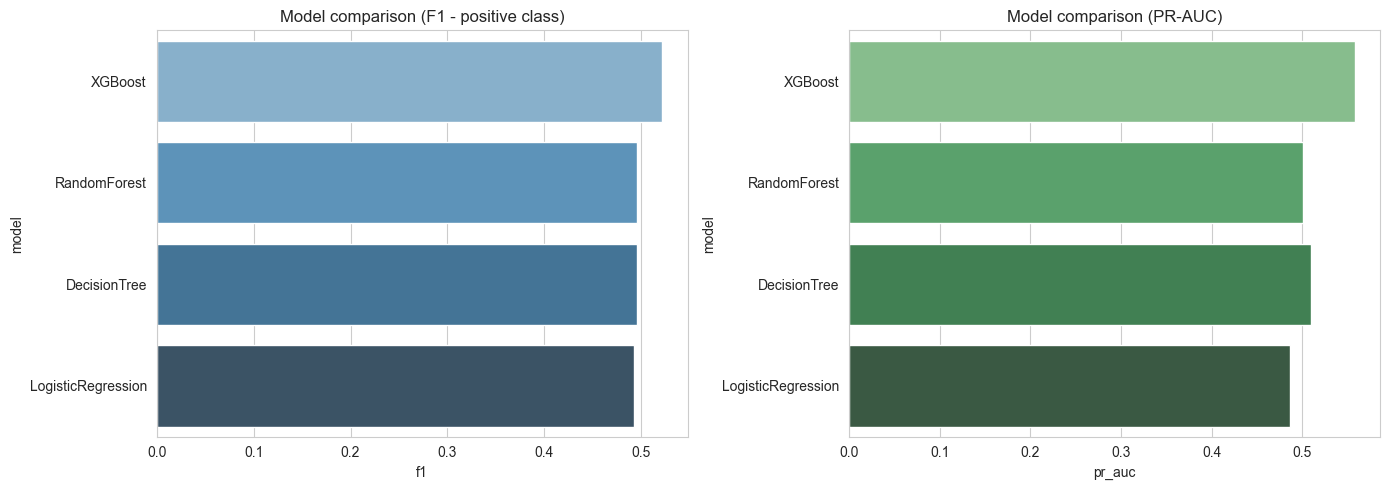

In [9]:
# Summarize results and create comparison chart
results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "model"})
results_df = results_df.sort_values("f1", ascending=False)
display(results_df)

# Bar chart: F1 and PR-AUC
fig, axes = plt.subplots(1, 2, figsize=(14,5))

# FIX: Added hue="model" and legend=False to suppress FutureWarning
sns.barplot(x="f1", y="model", data=results_df, ax=axes[0], palette="Blues_d", hue="model", legend=False)
axes[0].set_title("Model comparison (F1 - positive class)")

sns.barplot(x="pr_auc", y="model", data=results_df, ax=axes[1], palette="Greens_d", hue="model", legend=False)
axes[1].set_title("Model comparison (PR-AUC)")

plt.tight_layout()
plt.show()

In [10]:
# Choose champion by highest F1
champion_name = results_df.iloc[0]["model"]
print("Champion model chosen (by F1):", champion_name)

champion_pipeline = pipelines[champion_name]

# Fit champion on full dataset (X, y)
print("Fitting champion model on full dataset...")
champion_pipeline.fit(X, y)

# Save pipeline (preprocessor + model) for deployment/prescription
out_path = "../data/ponpare_v2_pipeline.joblib"
joblib.dump(champion_pipeline, out_path, compress=3)
print("Saved champion pipeline to:", out_path)

# Save results table
results_df.to_csv("../data/model_comparison_results.csv", index=False)
print("Saved model comparison results to ../data/model_comparison_results.csv")

Champion model chosen (by F1): XGBoost
Fitting champion model on full dataset...
Saved champion pipeline to: ../data/ponpare_v2_pipeline.joblib
Saved model comparison results to ../data/model_comparison_results.csv


--- Analyzing Feature Importance for XGBoost ---


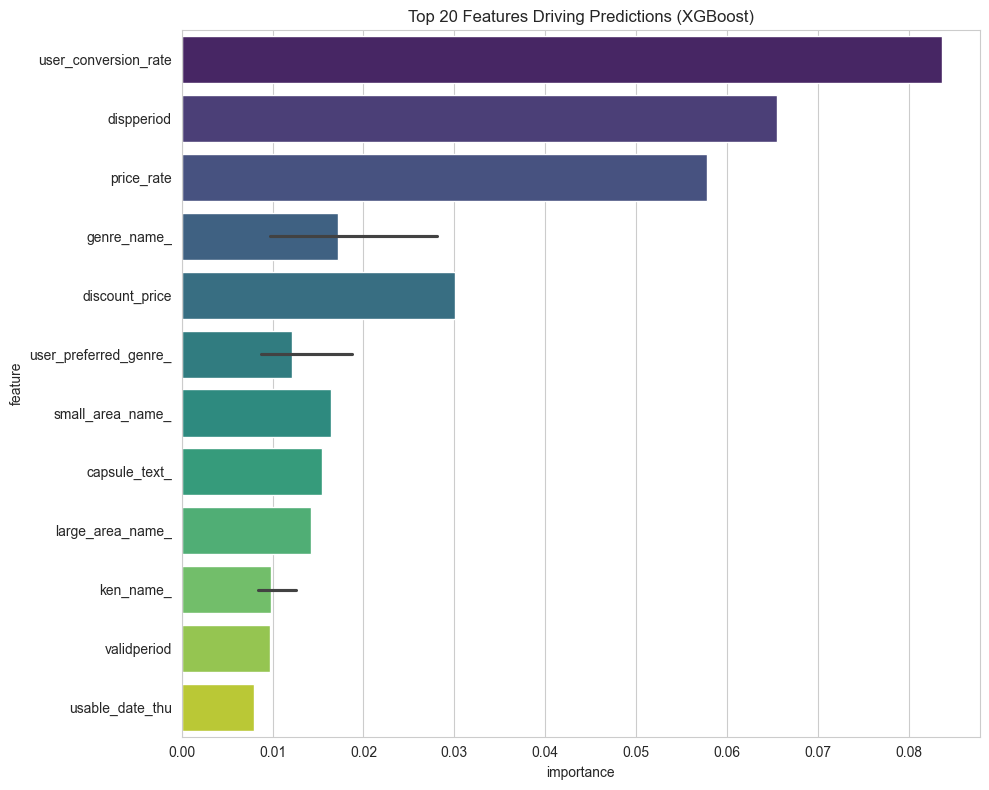


 VERIFYING V2 NEW FEATURES:
'discount_value' found, Rank: #47 (Importance: 0.0052)
'avg_time_between_visits' found, Rank: #133 (Importance: 0.0024)
'visit_month' found, Rank: #27 (Importance: 0.0070)
'visit_hour' found, Rank: #62 (Importance: 0.0043)
'user_conversion_rate' found, Rank: #1 (Importance: 0.0836)


In [13]:
# Feature Importance (Cleaned labels,removed japanese text)
import re

model = champion_pipeline.named_steps["model"]
pre = champion_pipeline.named_steps["preprocessor"]

print(f"--- Analyzing Feature Importance for {champion_name} ---")

# 1. Extract Feature Names
try:
    num_names = numeric_cols
    cat_encoder = pre.named_transformers_["cat"].named_steps["onehot"]
    cat_names = cat_encoder.get_feature_names_out(categorical_cols).tolist()
    feature_names = np.concatenate([num_names, cat_names])
except Exception as e:
    print("Could not extract feature names automatically:", e)
    feature_names = None

# 2. Plot Top 20 Features (With Japanese text removal)
if hasattr(model, "feature_importances_") and feature_names is not None:
    importances = model.feature_importances_
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    # FIX: Remove Japanese characters (non-ASCII) from feature names for clean plotting
    fi_df['feature'] = fi_df['feature'].apply(lambda x: re.sub(r'[^\x00-\x7F]+', '', str(x)))
    
    fi_df = fi_df.sort_values(by='importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(10, 8))
    # Added hue and legend parameters to satisfy the new library rules
    sns.barplot(x="importance", y="feature", data=fi_df.head(20), palette="viridis", hue="feature", legend=False)
    plt.title(f"Top 20 Features Driving Predictions ({champion_name})")
    plt.tight_layout()
    plt.show()
    
    # 3. V2 FEATURE VERIFICATION
    print("\n VERIFYING V2 NEW FEATURES:")
    # We verify against the ORIGINAL list to match your expectations, 
    # but we check if they exist in the cleaned names now.
    new_features = ['discount_value', 'avg_time_between_visits', 'visit_month', 'visit_hour', 'user_conversion_rate']
    
    for feat in new_features:
        match = fi_df[fi_df['feature'].astype(str).str.contains(feat, case=False)]
        if not match.empty:
            # Rank is 0-indexed, so add 1
            real_rank = fi_df.index.get_loc(match.index[0]) + 1
            score = match.iloc[0]['importance']
            print(f"'{feat}' found, Rank: #{real_rank} (Importance: {score:.4f})")
        else:
            print(f"'{feat}' not found in top features.")

else:
    print(f"Model {champion_name} does not support feature importance.")

In [14]:
# Summarize model and save results
print("Final Model Summary:")
display(results_df)
print("Champion:", champion_name)
print("Pipeline saved at:", out_path)

Final Model Summary:


,model,accuracy,f1,recall,precision,roc_auc,pr_auc,brier
3,XGBoost,0.711537,0.521582,0.726848,0.406722,0.800956,0.557696,0.180080
2,RandomForest,0.671198,0.495212,0.745513,0.370739,0.773531,0.500150,0.203522
1,DecisionTree,0.678679,0.495073,0.728145,0.375029,0.774978,0.508948,0.194379
0,LogisticRegression,0.690695,0.492947,0.694978,0.381921,0.769082,0.486233,0.198189


Champion: XGBoost
Pipeline saved at: ../data/ponpare_v2_pipeline.joblib
